### 模型评估和模型选择
需要时刻注意的是，我们正在解决的是一项有监督回归任务：使用纽约市建筑的能源数据，开发一个能够预测建筑物能源之星评分的模型。预测的准确性和模型的可解释性是最重要的两个指标。

从大量现有的机器学习模型中选择出适用的模型并不是一件容易的事。尽管有些“模型分析图表”（如下图）试图告诉你要去选择哪一种模型，但亲自去尝试多种算法，并根据结果比较哪种模型效果最好，也许是更好的选择。机器学习仍然是一个主要由经验（实验）而不是理论结果驱动的领域，事先就知道哪种模型最好，几乎是不可能的。

参考链接：https://blog.csdn.net/fendouaini/article/details/80571694


我们将评估涵盖复杂模型的五种不同模型：

1. 线性回归（LR）
2. K-近邻（KNN）
3. 随机森林（RF）
4. 梯度提升（GBM）
5. 支持向量机（SVM）

#### 读入数据

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


In [3]:
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

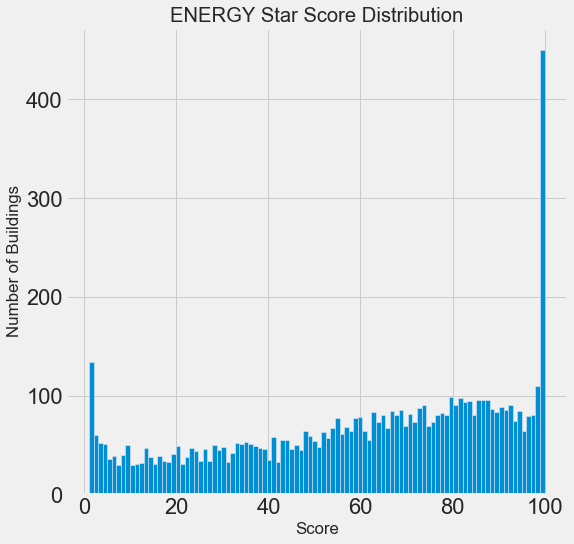

In [4]:
figsize(8, 8)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('ENERGY Star Score Distribution');

#### 缺失值填补
每一个NaN代表一个缺失对象。有着多种方法可以填补缺失数据（https://www.omicsonline.org/open-access/a-comparison-of-six-methods-for-missing-data-imputation-2155-6180-1000224.php?aid=54590 ），这里使用一种一种相对简单的方法–中值插补法。通过使用这个方法，每一列中的缺失对象都会被该列的中值所替换列。


在下面的代码中，我们借用Scikit-Learn库中封装好的函数创建了一个以“中值替换”（median）为填补策略的Imputer对象。然后，在训练集上（使用imputer.fit函数）上训练这个对象，并用imputer.transform函数填充所有数据（训练集+测试集）中的缺失值。也就是说，测试集中的缺失值也会被相对应训练集中的中值所填充。

（以这样的方式做“插补”是很有必要的，若是对所有数据进行训练以得出中值可能造成“测试数据泄漏”(详见：https://www.kaggle.com/dansbecker/data-leakage)问题–测试集中的信息有可能溢出到训练数据中。）

In [5]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [7]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


#### 特征缩放
特征缩放是一种用于标准化自变量或数据特征范围的方法。在数据处理中，它也被称为数据标准化。数据中的各项特征是以不同单位测量得到的，因此涵盖了不同的范围，所以进行特征缩放是很有必要的。诸如支持向量机和K近邻这些会考虑各项特征之间距离的方法显著地受到这些特征范围的影响，特征缩放对这些模型来说是很重要的，进行特征缩放使得他们能够学习数据特征。尽管像线性回归和随机森林等方法实际上并不需要特征缩放，但在比较多种算法时进行这一步骤仍然是最佳选择。

接下来通过“将每个特征值放置在0到1之间”来缩放特征。具体来说，我们先获取每个特征的每一个值，然后减去对应特征的最小值并除以特征值区间（区间=最大值减最小值）来完成。这种操作在特征缩放中通常被称为归一化（normalization），另一个主要方法是标准化（standardization）。

尽管这个过程很容易手动实现，但这里我们可以使用Scikit-Learn中的MinMaxScale函数实现。此方法的代码与插补相似。同样地，我们仅使用训练数据进行训练，然后转换所有数据（训练集+测试集）。

In [8]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [9]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

#### 在Scikit-Learn中实现机器学习模型
演示模型创建、训练（使用.fit函数）和预测（使用.predict函数）

In [10]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [11]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [12]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [13]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MAE = 10.0073


In [14]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0144


In [15]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


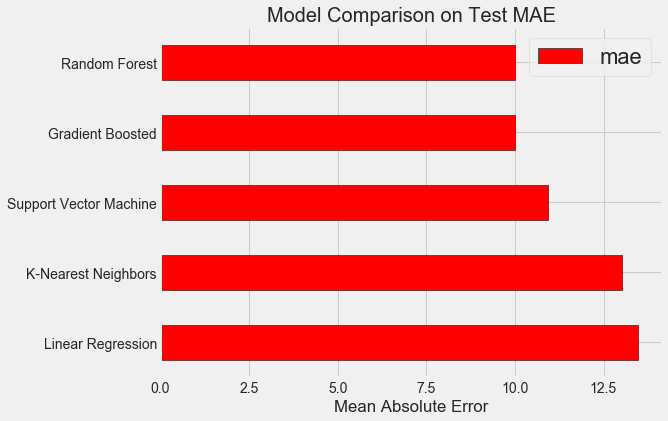

In [16]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

我们之前使用目标中值计算的基线（baseline）为24.5，从上图中可以很清晰的对比模型表现。显然，机器学习的表现比基线（baseline）有了显著的改进，它适用于我们的问题。

梯度增加法（GBM）的平均绝对误差（MAE = 10.013）微小的领先击败了随机森林（RF：MAE=10.014）。值得注意的是，由于我们使用超参数的默认值，所以这些结果并不完全代表模型最终的表现。尤其是诸如支持向量机（SVM）这类模型，它们的性能高度依赖于这些超参数设置。尽管如此，通过上图中的表现对比分析，我们还是选择梯度提升回归模型并在接下来的步骤中对其进行优化处理。

#### 模型优化之超参数调整
对于机器学习任务，在选择了一个模型后我们可以针对我们的任务调整模型超参数来优化模型表现。

首先，超参数是什么，它们与普通参数有什么不同？

模型超参数通常被认为是数据科学家在训练之前对机器学习算法的设置。例如：随机森林算法中树的个数或K-近邻算法中设定的邻居数。
模型参数是模型在训练期间学习的内容，例如线性回归中的权重。
超参数的设定影响着模型“欠拟合”与“过拟合”的平衡，进而影响模型表现。欠拟合是指我们的模型不足够复杂（没有足够的自由度）去学习从特征到目标特征的映射。一个欠适合的模型有着很高的偏差（bias），我们可以通过增加模型的复杂度来纠正这种偏差（bias）。

过拟合是指我们的模型过渡记忆了训练数据的情况。过拟合模型具有很高的方差（详见：https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff）。针对这种情况，我们可以通过正则化来限制模型的复杂度来纠正。“欠拟合”和“过拟合”在测试集上都不会有较好的表现。

对于每一个机器学习问题，都有着特有的最优超参数组合。因此，找到最佳超参数设置的唯一方法就是尝试多种超参数设置来分析哪一个表现最佳。幸运的是，Scikit-Learn中有多种方法可以让我们高效地评估超参数。此外，也有一些其他的方式选取最优超参数，例如Epistasis Lab的TPOT（https://epistasislab.github.io/tpot/ ）等项目正试图使用遗传算法等方法优化超参数搜索。

#### 随机搜索与交叉验证
我们使用随机搜索（Randam Search）来为我们的模型选择最佳超参数。我们定义一个网格（grid）后采用的是随机抽样的方式（random search）选取不同的超参数组合而不是像网格搜索尝试每一个超参数组合。（值得一提的是，使用随机搜索方法选择超参数的表现几乎和网格搜索一样，同时大大缩短了搜索时间。）
我们使用交叉验证（Cross Validation）的方法来评估所选超参数组合表现。这里我们选择使用K-Fold交叉验证，而不是将训练集直接分成单独的训练集和验证集，那样会减少我们可以使用的训练数据量。在k-折交叉验证中，原始样本被随机划分为k等份子样本。在k份子样本中，保留一个子样本作为测试模型的验证集，剩下的k-1子样本用作模型训练。重复进行k次（the folds）交叉验证过程，每一个子样本都作为验证数据被使用一次。然后，这些折叠的k结果可以被平均（或其他组合）产生一个单一的估计。最后，我们将K次迭代的平均误差作为最终的性能指标。
K = 5的K-fold交叉验证过程如下所示：

使用随机搜索与交叉验证验证选择最优超参数组合的步骤为：

-设置一个超参数的网格（grid）用于评估

随机抽样一组超参数
用选定的超参数组合创建一个模型
使用K-fold交叉验证评估模型
确定表现最佳的超参数组合
当然，我们实际上是调用Scikit-Learn工具库中封装好的RandomizedSearchCV函数来实现上述操作的。

原文链接：https://blog.csdn.net/fendouaini/article/details/80699442

##### 超参数调整
loss：损失函数的最小值设定
n_estimators：所使用的弱“学习者”（决策树）的数量
max_depth：决策树的最大深度
min_samples_leaf：决策树的叶节点所需的最小示例个数
min_samples_split：分割决策树节点所需的最小示例个数
max_features：最多用于分割节点的特征个数
完全弄懂这些超参数之间的相互作用是比较难的，所以最佳的方式就是去尝试多种超参数组合。


##### 在测试集上评估最佳模型
在测试集上进行预测并评价性能是相对直接的方式。
机器学习的一个基本特性：它是一种“权衡游戏”。我们需要不断地平衡准确性与可解释性、偏差与方差、准确性与运行时间等表现。正确的混合将最终取决于问题。本项目中，相对而言运行时间增加12倍是恐怖的，但绝对而言又不是显著（增加了十几秒）

In [17]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [18]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [19]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.2min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

In [20]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,21.020702,0.665079,0.029752,0.000829,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.859660,-8.775078,-9.325044,-9.037550,-8.999278,0.210556,1,-7.027368,-6.837958,-6.869084,-6.840749,-6.893790,0.078077
3,21.360222,0.435216,0.029502,0.001803,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.870442,-8.903982,-9.317120,-9.075047,-9.041601,0.176957,2,-4.482073,-4.326121,-4.823009,-4.229809,-4.465253,0.225313
9,13.420767,0.912695,0.022001,0.002450,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.133949,-9.042221,-9.439618,-9.153004,-9.192167,0.148852,3,-7.007604,-7.088986,-6.913108,-6.940327,-6.987506,0.067939
0,4.475756,0.317554,0.008500,0.000866,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.100775,-9.026372,-9.457063,-9.201235,-9.196321,0.162799,4,-7.302003,-7.312645,-7.173397,-7.386171,-7.293554,0.076569
7,11.378401,1.231014,0.021501,0.000500,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.147703,-9.199053,-9.698781,-9.358627,-9.350987,0.215296,5,-7.089709,-7.103749,-7.021418,-7.080088,-7.073741,0.031358
10,108.628213,6.290412,0.128007,0.009355,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.257896,-9.242743,-9.530568,-9.475944,-9.376750,0.128046,6,-0.378166,-0.459465,-0.393491,-0.370483,-0.400401,0.035092
19,28.711642,1.224956,0.043002,0.003937,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-9.379266,-9.382812,-9.475236,-9.291753,-9.382266,0.064885,7,-8.311796,-8.658903,-7.820534,-8.017995,-8.202307,0.316303
2,70.783549,5.905061,0.077504,0.014942,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.392251,-9.291198,-9.575363,-9.429866,-9.422145,0.101949,8,-0.164859,-0.193613,-0.164415,-0.141062,-0.165987,0.018629
16,41.985151,4.099035,0.073754,0.017298,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.248892,-9.316306,-9.798843,-9.427920,-9.447940,0.212403,9,-4.821677,-4.876202,-4.776650,-4.729506,-4.801009,0.054284
21,6.788888,0.224379,0.034752,0.004969,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.394785,-9.286988,-9.751767,-9.409179,-9.460643,0.174556,10,-5.684121,-5.742441,-5.571781,-5.666476,-5.666205,0.061337


In [21]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [23]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.2min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samp...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

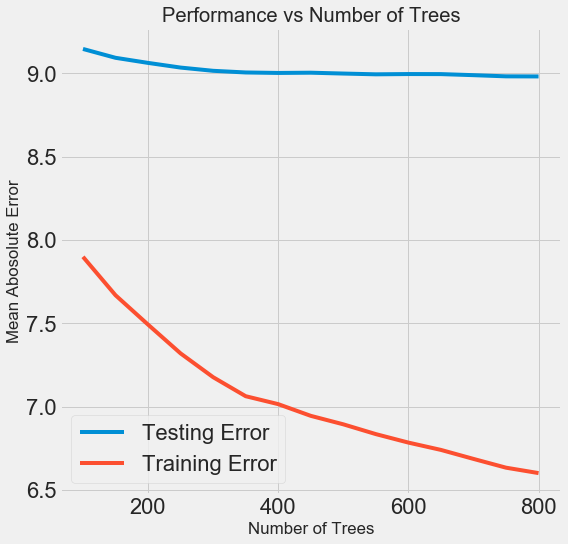

In [24]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [25]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
14,30.728007,6.026444,0.037752,0.005540,800,{'n_estimators': 800},-8.825290,-8.758299,-9.296941,-9.047485,-8.981946,0.210990,1,-6.739448,-6.648109,-6.486269,-6.530287,-6.601028,0.099437
13,34.001445,2.106336,0.046003,0.005099,750,{'n_estimators': 750},-8.830566,-8.751699,-9.298411,-9.049730,-8.982544,0.212523,2,-6.772908,-6.660453,-6.520818,-6.579989,-6.633542,0.094501
12,31.210535,4.193647,0.040752,0.003767,700,{'n_estimators': 700},-8.836049,-8.755862,-9.312990,-9.053755,-8.989605,0.216159,3,-6.812928,-6.695770,-6.611240,-6.624919,-6.686214,0.079884
9,25.108436,1.377670,0.040002,0.015051,550,{'n_estimators': 550},-8.853730,-8.756938,-9.325492,-9.042721,-8.994663,0.216865,4,-7.003413,-6.781878,-6.809121,-6.745712,-6.835031,0.099783
11,29.224422,2.431493,0.045753,0.015818,650,{'n_estimators': 650},-8.851136,-8.755401,-9.325190,-9.052215,-8.995928,0.218168,5,-6.864375,-6.721452,-6.708191,-6.666758,-6.740194,0.074480


In [26]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

929 ms ± 11.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [28]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

14 s ± 208 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [30]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 10.0130.
Final model performance on the test set:   MAE = 9.0453.


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


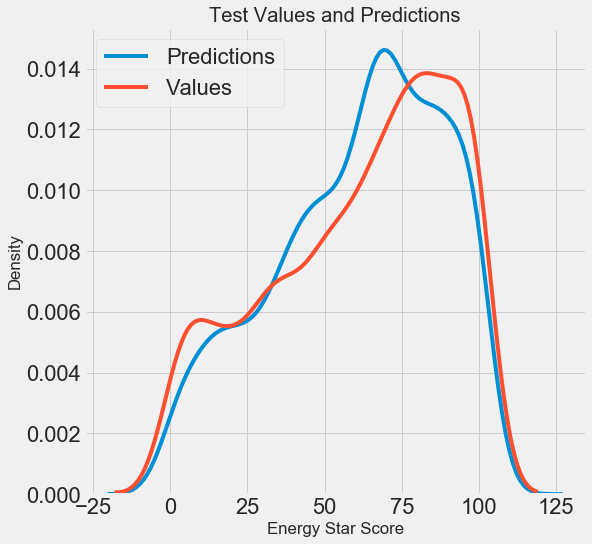

In [31]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

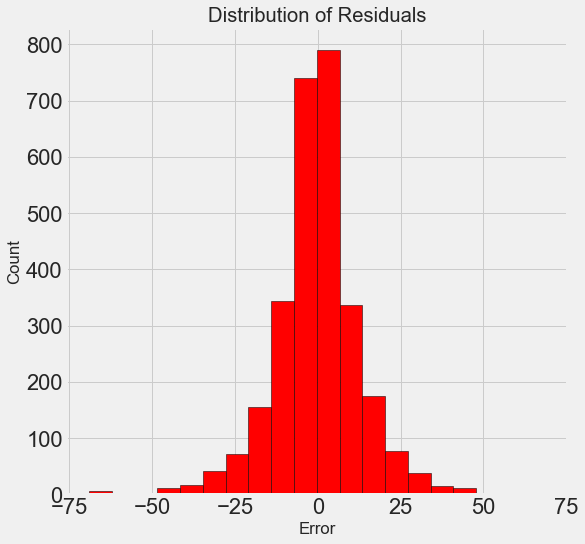

In [32]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

## 结论
我们介绍了机器学习工作流程中的以下几个步骤：

1. 使用随机网格搜索和交叉验证进行超参数调整
2. 在测试集上评估最佳模型
本次工作的结果表明，机器学习适用于本次任务-使用能源数据建立一个模型，可以预测建筑物的能源之星评分（ENERGY STAR Score)。使用梯度提升回归模型能够在测试集上的表现达到9.1分左右。此外，超参数调整可以在增加时间成本的情况下显著提高模型性能。虽然从实际表现来看我们的模型预测是准确的，但是我们也许想要或者应该知道模型可以做出来这种预测的原因和这些表现在针对我们的任务方面，实际上告诉了我们什么。
